#Inference on SNLI with BiLSTM

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import spacy
import re
import string
import time

from collections import Counter
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 7.7 MB/s eta 0:00:01    |███████████▎                    | 4.2 MB 7.7 MB/s eta 0:00:02
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


##Set random seed

In [ ]:
SEED = 1

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preprocess data

### Import data

In [ ]:
train = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_train.csv')
test = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_test.csv')
valid = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_dev.csv')

### Remove null data points

In [ ]:
train.isnull().sum()

gold_label                     0
sentence1_binary_parse         0
sentence2_binary_parse         6
sentence1_parse                0
sentence2_parse                0
sentence1                      0
sentence2                      6
captionID                      0
pairID                         0
label1                         0
label2                    510782
label3                    510757
label4                    510769
label5                    513238
dtype: int64

In [ ]:
train = train.dropna(subset = ['sentence2'])
train = train[train["gold_label"] != "-"]
test = test[test["gold_label"] != "-"]
valid = valid[valid["gold_label"] != "-"]

In [ ]:
train.isnull().sum()

gold_label                     0
sentence1_binary_parse         0
sentence2_binary_parse         0
sentence1_parse                0
sentence2_parse                0
sentence1                      0
sentence2                      0
captionID                      0
pairID                         0
label1                         0
label2                    510769
label3                    510740
label4                    510753
label5                    512937
dtype: int64

### Tokenize data

In [ ]:
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [ ]:
counts = Counter()
for index, row in train.iterrows():
    counts.update(tokenize(row['sentence1']+row['sentence2']))

In [ ]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 38910
num_words after: 26602


In [ ]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
def encode_sentence(text, vocab2index, N=80):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
train['premi'] = train['sentence1'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
train['hypo'] = train['sentence2'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
valid['premi'] = valid['sentence1'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
valid['hypo'] = valid['sentence2'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
test['premi'] = test['sentence1'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
test['hypo'] = test['sentence2'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5,premi,hypo
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN,"[[2, 3, 4, 2, 5, 6, 7, 2, 8, 9, 10, 0, 0, 0, 0...","[[2, 3, 11, 12, 13, 5, 14, 2, 15, 0, 0, 0, 0, ..."
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN,"[[2, 3, 4, 2, 5, 6, 7, 2, 8, 9, 10, 0, 0, 0, 0...","[[2, 3, 11, 16, 2, 17, 18, 19, 20, 21, 0, 0, 0..."
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN,"[[2, 3, 4, 2, 5, 6, 7, 2, 8, 9, 10, 0, 0, 0, 0...","[[2, 3, 11, 22, 18, 4, 2, 5, 0, 0, 0, 0, 0, 0,..."
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN,"[[23, 24, 25, 26, 16, 377, 0, 0, 0, 0, 0, 0, 0...","[[213, 27, 24, 16, 28, 29, 0, 0, 0, 0, 0, 0, 0..."
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN,"[[23, 24, 25, 26, 16, 377, 0, 0, 0, 0, 0, 0, 0...","[[90, 27, 23, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [ ]:
numb = {'contradiction':0, 'neutral':1, 'entailment':2}
train['gold_label'] = train['gold_label'].apply(lambda x: numb[x])
valid['gold_label'] = valid['gold_label'].apply(lambda x: numb[x])
test['gold_label'] = test['gold_label'].apply(lambda x: numb[x])

In [ ]:
premi = list(train['premi'])
hypo = list(train['hypo'])
y_train = list(train['gold_label'])

In [ ]:
premi_val = list(valid['premi'])
hypo_val = list(valid['hypo'])
y_train_val = list(valid['gold_label'])

In [ ]:
premi_test = list(test['premi'])
hypo_test = list(test['hypo'])
y_train_test = list(test['gold_label'])

### Load data into Datasets and then Dataloaders

In [ ]:
class Ds(Dataset):
    def __init__(self, X1,X2, Y):
        self.X1 = X1
        self.X2 = X2
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X1[idx][0].astype(np.int32)),torch.from_numpy(self.X2[idx][0].astype(np.int32)), self.y[idx]

In [ ]:
train_ds = Ds(premi,hypo,y_train)
val_ds = Ds(premi_val,hypo_val,y_train_val)
test_ds = Ds(premi_test,hypo_test,y_train_test)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2048, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=2048, shuffle=True)

## Activating GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

### Shifting DataLoaders to GPU

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## Checking the shape of final data

In [ ]:
for batch in train_dl:
    a,b,c = batch
    print(a.shape,b.shape,c)
    break

torch.Size([2048, 80]) torch.Size([2048, 80]) tensor([2, 0, 0,  ..., 1, 0, 1], device='cuda:0')


In [ ]:
vocab_size = len(words)
vocab_size

26604

## Building the model

In [ ]:
class Model(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, 512, padding_idx=0)
        self.trans = nn.Linear(512,128)
        self.lstm = nn.LSTM(128, 128, batch_first=True,num_layers =2, bidirectional = True)
        self.linear1 = nn.Linear(512, 1024)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 64)
        self.linear4 = nn.Linear(64, 16)
        self.linear5 = nn.Linear(16, 3)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.LogSoftmax(dim=1)
        
    def forward(self, x1, x2):
        
        x1 = self.embeddings(x1)
        x1 = self.trans(x1)
        x1 = self.dropout(x1)
        _,(x1,_) = self.lstm(x1)
        
        x2 = self.embeddings(x2)
        x2 = self.trans(x2)
        x2 = self.dropout(x2)
        _,(x2,_) = self.lstm(x2)
        
        x1 = torch.cat((x1[-1], x1[-2]), dim=-1)
        x2 = torch.cat((x2[-1], x2[-2]), dim=-1)

        combined = torch.cat((x1, x2), dim=1)
        
        combined = F.relu(self.linear1(combined))
        combined = self.dropout(combined)
        
        combined = F.relu(self.linear2(combined))
        combined = self.dropout(combined)
        
        combined = F.relu(self.linear3(combined))
        combined = self.dropout(combined)
        
        combined = F.relu(self.linear4(combined))
        combined = self.dropout(combined)
        
        combined = F.relu(self.linear5(combined))
        combined = self.out(combined)
        
        return combined

In [ ]:
model =  Model()
model = to_device(model, device)

In [ ]:
criterion = nn.NLLLoss().to(device)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0013)

### Defining accuracy, evaluation and training functions

In [ ]:
def categorical_accuracy(preds, y):
    
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    correct = correct.to('cpu')
    y = y.to('cpu')
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            prem,hypo,labels = batch
            prem = prem.long()
            hypo = hypo.long()
            labels = labels.long()
        
            predictions = model(prem, hypo)
            
            loss = criterion(predictions, labels)
                
            acc = categorical_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        prem,hypo,labels = batch
        prem = prem.long()
        hypo = hypo.long()
        labels = labels.long()
        
        optimizer.zero_grad()
        
        #prem = [prem sent len, batch size]
        #hypo = [hypo sent len, batch size]
        
        predictions = model(prem, hypo)
        
        #predictions = [batch size, output dim]
        #labels = [batch size]
        
        loss = criterion(predictions, labels)
                
        acc = categorical_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training the model

In [ ]:
N_EPOCHS = 15

tr_loss = []
vl_loss = []
tr_acc = []
vl_acc = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_dl, criterion)
    
    tr_loss.append(train_loss)
    vl_loss.append(valid_loss)
    tr_acc.append(train_acc)
    vl_acc.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

Epoch: 01 | Epoch Time: 1m 16s
	Train Loss: 0.975 | Train Acc: 45.11%
	 Val. Loss: 0.891 |  Val. Acc: 48.33%
Epoch: 02 | Epoch Time: 1m 16s
	Train Loss: 0.818 | Train Acc: 59.89%
	 Val. Loss: 0.691 |  Val. Acc: 70.98%
Epoch: 03 | Epoch Time: 1m 17s
	Train Loss: 0.681 | Train Acc: 71.95%
	 Val. Loss: 0.632 |  Val. Acc: 73.70%
Epoch: 04 | Epoch Time: 1m 17s
	Train Loss: 0.625 | Train Acc: 74.73%
	 Val. Loss: 0.601 |  Val. Acc: 75.51%
Epoch: 05 | Epoch Time: 1m 16s
	Train Loss: 0.588 | Train Acc: 76.43%
	 Val. Loss: 0.577 |  Val. Acc: 76.56%
Epoch: 06 | Epoch Time: 1m 16s
	Train Loss: 0.559 | Train Acc: 77.80%
	 Val. Loss: 0.571 |  Val. Acc: 77.15%
Epoch: 07 | Epoch Time: 1m 17s
	Train Loss: 0.534 | Train Acc: 78.91%
	 Val. Loss: 0.554 |  Val. Acc: 77.96%
Epoch: 08 | Epoch Time: 1m 17s
	Train Loss: 0.514 | Train Acc: 79.90%
	 Val. Loss: 0.548 |  Val. Acc: 78.56%
Epoch: 09 | Epoch Time: 1m 17s
	Train Loss: 0.495 | Train Acc: 80.69%
	 Val. Loss: 0.548 |  Val. Acc: 78.57%
Epoch: 10 | Epoch T

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_dl, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.548 |  Test Acc: 79.36%


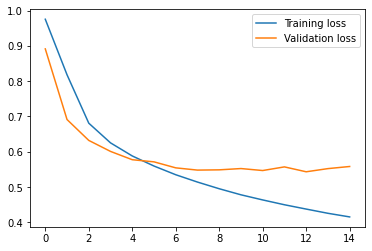

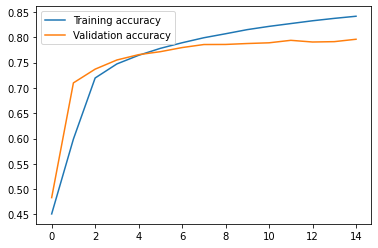

In [ ]:
plt.plot(tr_loss, label = "Training loss")
plt.plot(vl_loss, label = "Validation loss")
plt.legend()
plt.show()

plt.plot(tr_acc, label = "Training accuracy")
plt.plot(vl_acc, label = "Validation accuracy")
plt.legend()
plt.show()